In [1]:
import sys, os

import random
import statistics as stat
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import nilmtk

sys.path.append(os.path.dirname(os.getcwd()))

In [2]:
import adinilm.functions as F
from adinilm.enumerations import *
from adinilm.objs import DatasetProfile, ProfileHandler, NormalizationHandler
from adinilm.utils import paths_manager as pathsman
from adinilm.io import NilmtkSubsectionExtractor

In [3]:
## Variable declaration for dataset
UKDALE_BUILDING = 1
UKDALE_START_TIME = "2015-01-01"
# END_TIME = "2015-01-15"
UKDALE_END_TIME = "2015-01-15"

FRIDGE_FREEZER = "fridge"
KETTLE = "kettle"
DISHWASHER = "dish washer"
MICROWAVE = "microwave"
WASHER_DRYER = "washer dryer"

applist = [FRIDGE_FREEZER, WASHER_DRYER, KETTLE, DISHWASHER, MICROWAVE]

In [4]:
info = {
        "subsection" : {
                "building" : UKDALE_BUILDING,
                "start_time" : UKDALE_START_TIME,
                "end_time": UKDALE_END_TIME
        },
        "preprocessing" : [
                {
                        "activation_extension" : {
                                "mode" : "randomizer",
                                "num_full_samples" : 1200000
                        }
                },
                {
                        "normalization" : {
                                "mode" : "minmax",
                                "scope" : "local"
                        }
                }
        ],
        "appliances" : [FRIDGE_FREEZER, WASHER_DRYER, KETTLE, DISHWASHER, MICROWAVE],
        "appliance_data" : {
                FRIDGE_FREEZER : {
                        "window" : 50,
                        "min" : 0,
                        "max" : 0,
                        "on_power_threshold" : 10,
                },
                WASHER_DRYER : {               
                        "window" : 50,
                        "min" : 0,
                        "max" : 0,
                        "on_power_threshold" : 10,
                },
                KETTLE : {
                        "window" : 50,
                        "min" : 0,
                        "max" : 0,
                        "on_power_threshold" : 10,
                },
                DISHWASHER : {
                        "window" : 10,
                        "min" : 0,
                        "max" : 0,
                        "on_power_threshold" : 10,
                },
                MICROWAVE : {
                        "window" : 50,
                        "min" : 0,
                        "max" : 0,
                        "on_power_threshold" : 10,
                }
        }
}

In [5]:
ext = NilmtkSubsectionExtractor(dataset_path=pathsman.UKDALE_H5_PATH,
                                params={"start_time" : UKDALE_START_TIME,
                                        "end_time" : UKDALE_END_TIME,
                                        "building" : UKDALE_BUILDING,
                                        "appliances" : applist,
                                        "sample_period" : 1,
                                        "resample" : True,})

c:\users\mtinaco\dev\solutions\cos-algo-nilm\nilmtk\nilmtk\elecmeter.py:431: UserWarning: The provided sample_period (1) is shorter than the meter's sample_period (6)
  warn("The provided sample_period ({}) is shorter than the meter's sample_period ({})".format(
c:\users\mtinaco\dev\solutions\cos-algo-nilm\nilmtk\nilmtk\elecmeter.py:431: UserWarning: The provided sample_period (1) is shorter than the meter's sample_period (6)
  warn("The provided sample_period ({}) is shorter than the meter's sample_period ({})".format(
c:\users\mtinaco\dev\solutions\cos-algo-nilm\nilmtk\nilmtk\elecmeter.py:431: UserWarning: The provided sample_period (1) is shorter than the meter's sample_period (6)
  warn("The provided sample_period ({}) is shorter than the meter's sample_period ({})".format(
c:\users\mtinaco\dev\solutions\cos-algo-nilm\nilmtk\nilmtk\elecmeter.py:431: UserWarning: The provided sample_period (1) is shorter than the meter's sample_period (6)
  warn("The provided sample_period ({}) is s

In [6]:
ext.df.head(6)

,power_series,on_power_threshold,activations
fridge,2015-01-01 00:00:04+00:00 0.0 2015-01-01 00...,50.0,"[[0.0, 0.0, 103.0, 100.0, 97.0, 97.0, 95.0, 94..."
washer dryer,2015-01-01 00:00:01+00:00 0.0 2015-01-01 00...,20.0,"[[10.0, 10.0, 103.0, 103.0, 10.0, 10.0, 10.0, ..."
kettle,2015-01-01 00:00:04+00:00 1.0 2015-01-01 00...,10.0,"[[1.0, 1.0, 565.0, 2347.0, 2350.0, 2365.0, 238..."
dish washer,2015-01-01 00:00:05+00:00 1.0 2015-01-01 00...,10.0,"[[1.0, 1.0, 24.0, 23.0, 24.0, 24.0, 24.0, 6.0,..."
microwave,2015-01-01 00:00:02+00:00 1.0 2015-01-01 00...,200.0,"[[1.0, 1.0, 1632.0, 1623.0, 1619.0, 1612.0, 16..."
site meter,2015-01-01 00:00:00+00:00 138.639999 2015-0...,NaN,NaN


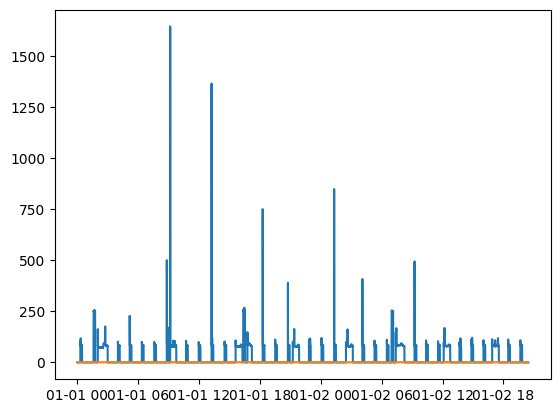

In [7]:
plt.plot(ext.df.loc[FRIDGE_FREEZER, "power_series"].iloc[:160000])
plt.plot(ext.df.loc[MICROWAVE, "power_series"].iloc[:160000])

In [8]:
FS = 1          # 1 Hz
DUR = 512       # 512 sec

In [9]:
SAMPLE_LENGTH = int(DUR * FS)

In [10]:
def quantile_filter_2(data, sequence_length, p=50):
    new_mains = F.scan_sequences(data=data, mode="odd_window", seq_len=sequence_length)
    new_mains = np.percentile(new_mains, p, axis=1, interpolation="nearest")
    return new_mains

In [21]:
class SubmeterDataframeFormatter:

        def __init__(self, applist: list):
                self.applist = applist

        def format(self, data : pd.DataFrame, *args, **kwargs) -> np.ndarray:
                finder = kwargs.get() if "finder" in kwargs else "power_series"
                data = data.loc[self.applist, finder]
                data = np.array([np.array(r) for r in data])
                return np.array(data)

        def __call__(self, data, *args, **kwargs):
                return self.format(data, *args, **kwargs)

In [22]:
## SUBMETER PREPROCESSING

formatter = SubmeterDataframeFormatter(applist=info["appliances"])

data_f = formatter(ext.df)


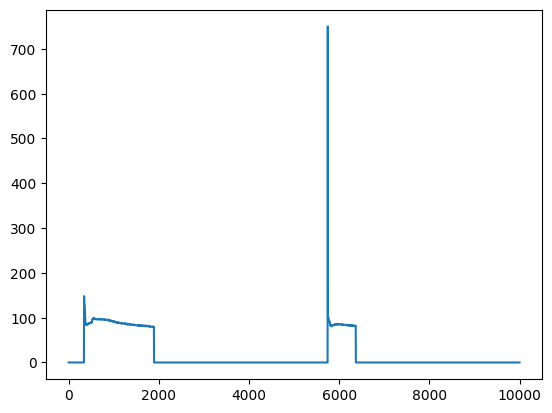

In [40]:
plt.plot(data_f[0,60000:70000])

In [41]:
class QuantileFilterApplier:

        def __init__(self, info, p=50):
                self.info = info
                self.p = p
        
        def filter(self, data, *args, **kwargs):
                apps = self.info["appliances"]
                data_c = data.copy()
                for i, app in enumerate(apps):
                        data_c[i,:] = quantile_filter_2(data[i,:], self.info["appliance_data"][app]["window"], p=self.p)
                return data_c
        
        def __call__(self, data, *args, **kwargs):
                return self.filter(data, *args, **kwargs)

In [42]:
filterer = QuantileFilterApplier(info)

data_filt = filterer(data_f)

C:\Users\MTinaco\AppData\Local\Temp\ipykernel_47368\361044578.py:3: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  new_mains = np.percentile(new_mains, p, axis=1, interpolation="nearest")


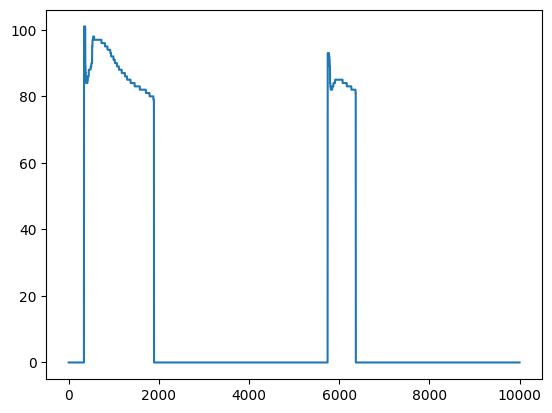

In [43]:
plt.plot(data_filt[0,60000:70000])